#### A Robust Pipeline for Synthetic Data Generation with CTGAN (https://github.com/sdv-dev/CTGAN)
##### An enhanced Python script featuring data preprocessing, quality evaluation and dataset generation.

In [1]:
import pandas as pd
from ctgan import CTGAN
from sdv.evaluation.single_table import evaluate_quality

# --- 1. Configuration & Best Practices ---

# Use variables for paths and parameters for easier management.

DATA_PATH = "data/synthetic_clinical_dataset.csv"

# Epoch Count
EPOCHS = 3000

# --- 2. Data Loading & Preprocessing ---
try:
    # We load the REAL data to train the model correctly.
    real_data = pd.read_csv(DATA_PATH)
    print(f"Successfully loaded data from {DATA_PATH}. Shape: {real_data.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {DATA_PATH}.")
    print("Please ensure the path is correct and the script is run from the right directory.")
    exit()

# Data Preprocessing (Missing Values)
if real_data.isnull().sum().any():
    print(f"Missing values found. Dropping {real_data.isnull().any(axis=1).sum()} rows with NaNs.")
    real_data.dropna(inplace=True)
    print(f"Data shape after dropping NaNs: {real_data.shape}")

# Defining columns that are categorical.
discrete_columns = [
    'menopausal_status',
    'parity',
    'family_history',
    'mht_use',
    'brca_status',
    'diagnosis_label'
]

# Column Names Mismatch
# A simple check to ensure all specified discrete columns exist in the DataFrame.
missing_cols = [col for col in discrete_columns if col not in real_data.columns]
if missing_cols:
    print(f"Error: The following discrete columns are not in the dataset: {missing_cols}")
    exit()

# --- 3. Model Training ---

# Initialize the CTGAN model with declared parameters.
ctgan = CTGAN(
    epochs=EPOCHS,
    # Class Imbalance - log_frequency helps handle imbalanced columns.
    #log_frequency=True,
    verbose=True # Set to True to see training progress.
)

print("\nStarting CTGAN model training...")
ctgan.fit(real_data, discrete_columns)
print("Training complete.")

# --- 4. Generate & Save Synthetic Data ---

print("\nGenerating synthetic data...")
# Create synthetic data with the same number of rows as the original data.
synthetic_data = ctgan.sample(len(real_data)*3)
print("Synthetic data generated successfully.")

# Save the data for later use.
synthetic_data.to_csv("data/synthetic_data_generated.csv", index=False)
print("Synthetic data saved to 'data/synthetic_data_generated.csv'")


# --- 5. Evaluation ---

# Evaluation of synthetic data quality.
print("\nEvaluating the quality of the synthetic data...")

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

# Pass the metadata object to the evaluation function ---
print("\nEvaluating the quality of the synthetic data...")
quality_report = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

# overall score (0..1)
overall = quality_report.get_score()
print("Overall quality score:", overall)

# list available properties
print("Available properties:", quality_report.get_properties())

# get details for a valid property
details = quality_report.get_details('Column Shapes')   # valid for single-table
print(details.head())

Successfully loaded data from data/synthetic_clinical_dataset.csv. Shape: (1000, 11)

Starting CTGAN model training...


Gen. (0.00) | Discrim. (0.00):   0%|                                                          | 0/3000 [00:00<?, ?it/s]C:\ProgramData\anaconda3\envs\GPUEnabled\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-0.77) | Discrim. (-0.04): 100%|█████████████████████████████████████████████| 3000/3000 [04:57<00:00, 10.08it/s]


Training complete.

Generating synthetic data...
Synthetic data generated successfully.
Synthetic data saved to 'data/synthetic_data_generated.csv'

Evaluating the quality of the synthetic data...

Evaluating the quality of the synthetic data...
Generating report ...

(1/2) Evaluating Column Shapes: |████████████████████████████████████████████████████| 11/11 [00:00<00:00, 203.40it/s]|
Column Shapes Score: 88.08%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 55/55 [00:00<00:00, 132.51it/s]|
Column Pair Trends Score: 85.85%

Overall Score (Average): 86.97%

Overall quality score: 0.8696931894111627
Available properties:              Property     Score
0       Column Shapes  0.880848
1  Column Pair Trends  0.858538
              Column        Metric     Score
0                age  KSComplement  0.956667
1  menopausal_status  TVComplement  0.909667
2                bmi  KSComplement  0.903667
3             parity  TVComplement  0.837667
4     fami

### Loss Function
##### Per CTGAN team experiments [(Link)](https://github.com/sdv-dev/CTGAN): When CTGAN performs well, both the generator and discriminator loss will eventually stabilize when they have run through enough epochs. In many of experiments, the generator loss started positive and eventually stabilized at a negative value while the discriminator loss oscillated around 0. This is shown below for a variety of different datasets. 

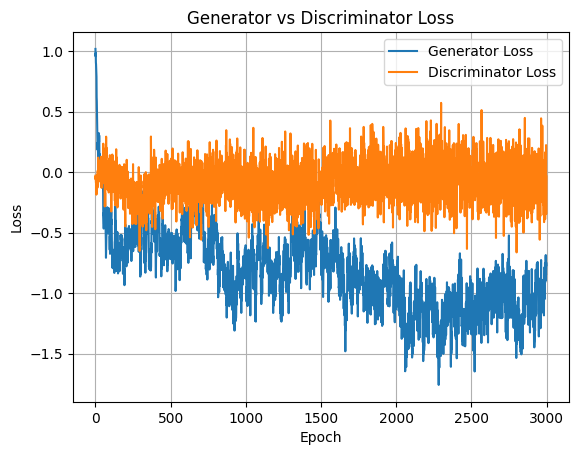

In [3]:
import matplotlib.pyplot as plt

plt.plot(ctgan.loss_values["Epoch"], ctgan.loss_values["Generator Loss"], label='Generator Loss'); plt.plot(ctgan.loss_values["Epoch"], ctgan.loss_values["Discriminator Loss"], label='Discriminator Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator vs Discriminator Loss'); plt.legend(); plt.grid(True); plt.show()


#### Benchmarking the new CTGAN- generated Synthetic Dataset Against the first Synthetic Dataset
##### Automated univariate, bivariate, and multivariate similarity checks (histograms, KDEs, heatmaps, PCA) via [TableEvaluator](https://github.com/Baukebrenninkmeijer/table-evaluator)

IPython not installed.
(1000, 11) (3000, 11)


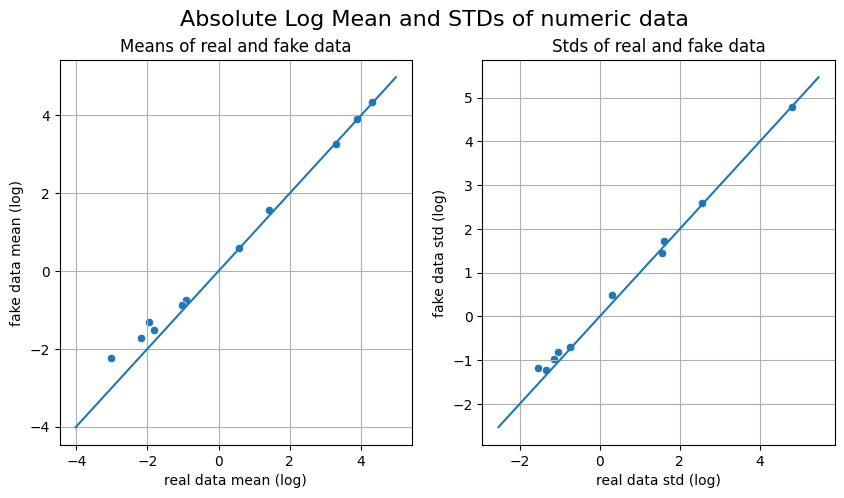

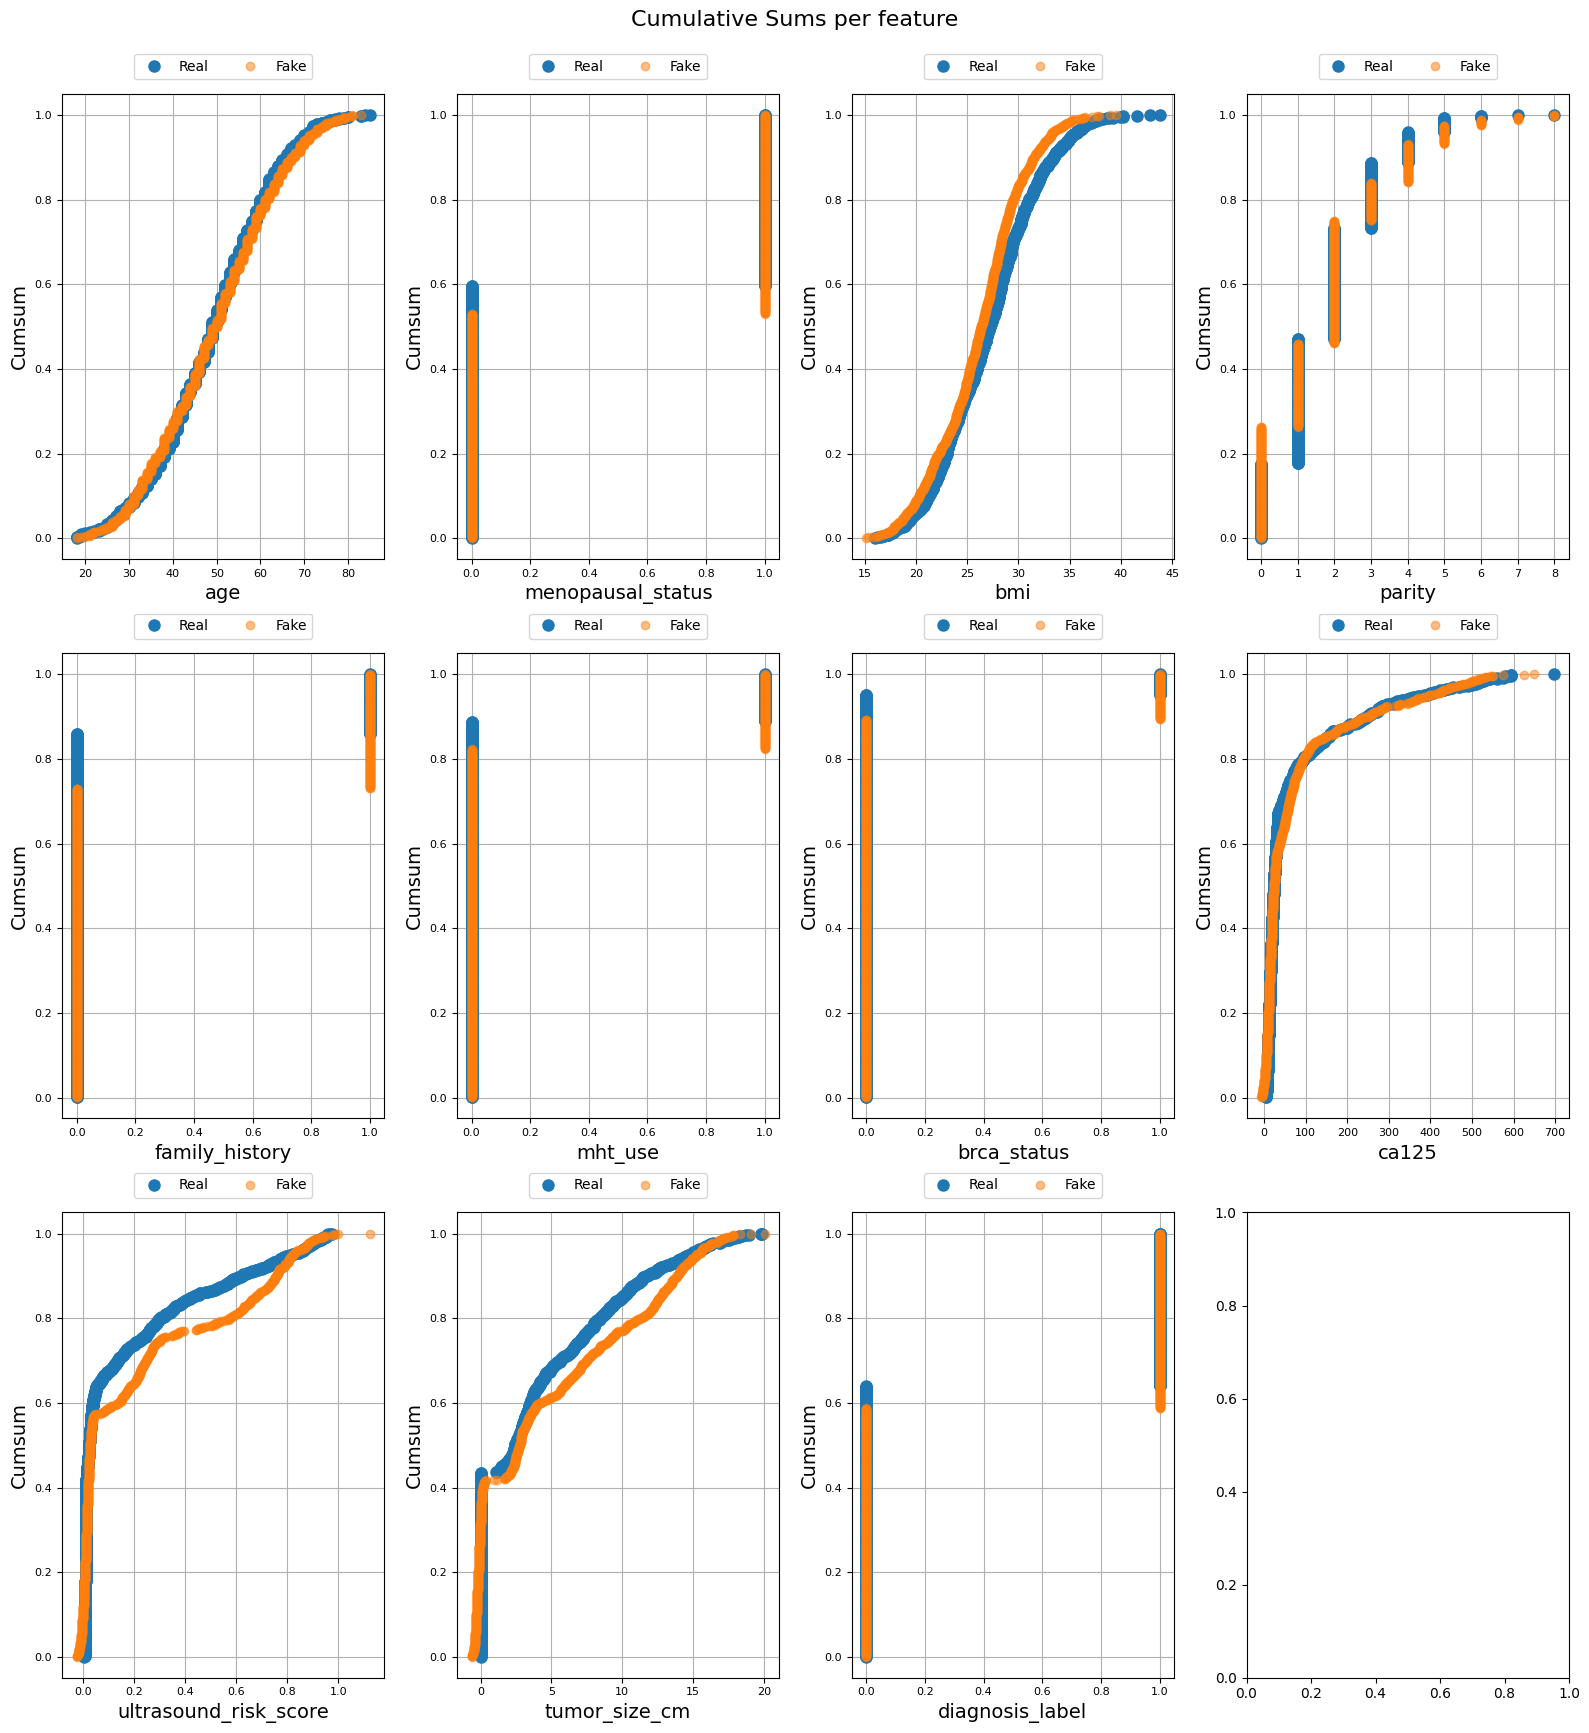

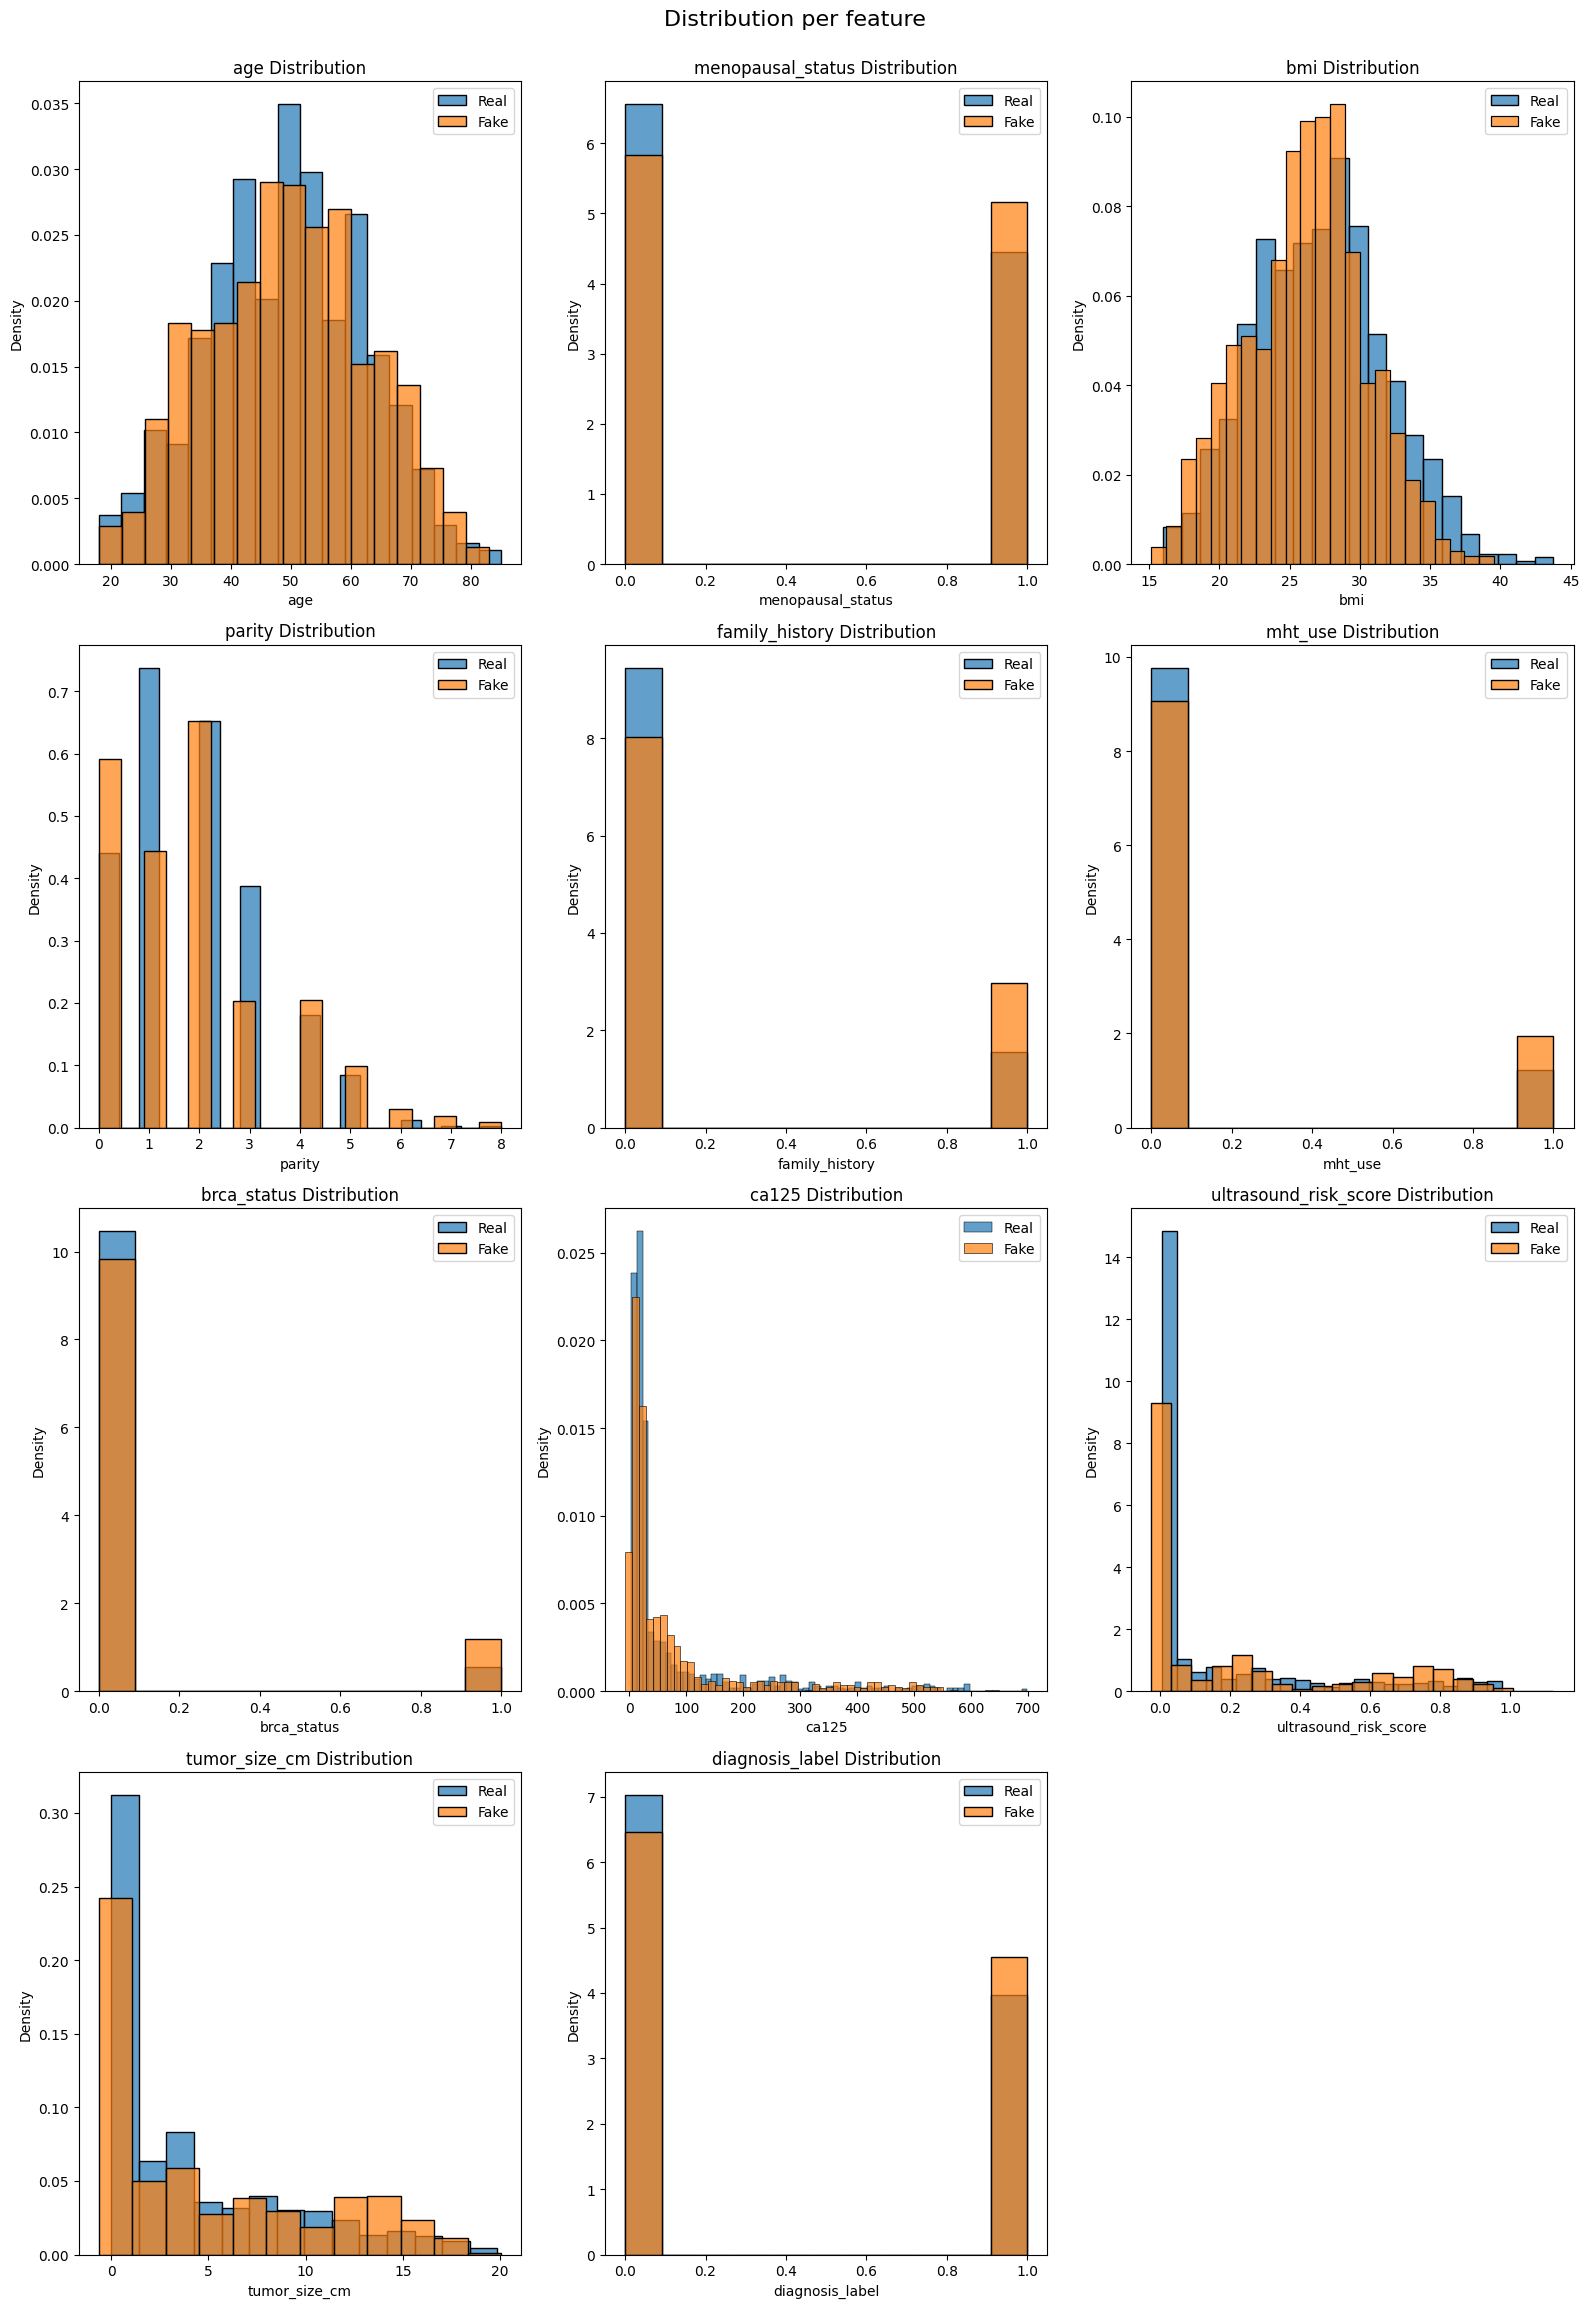

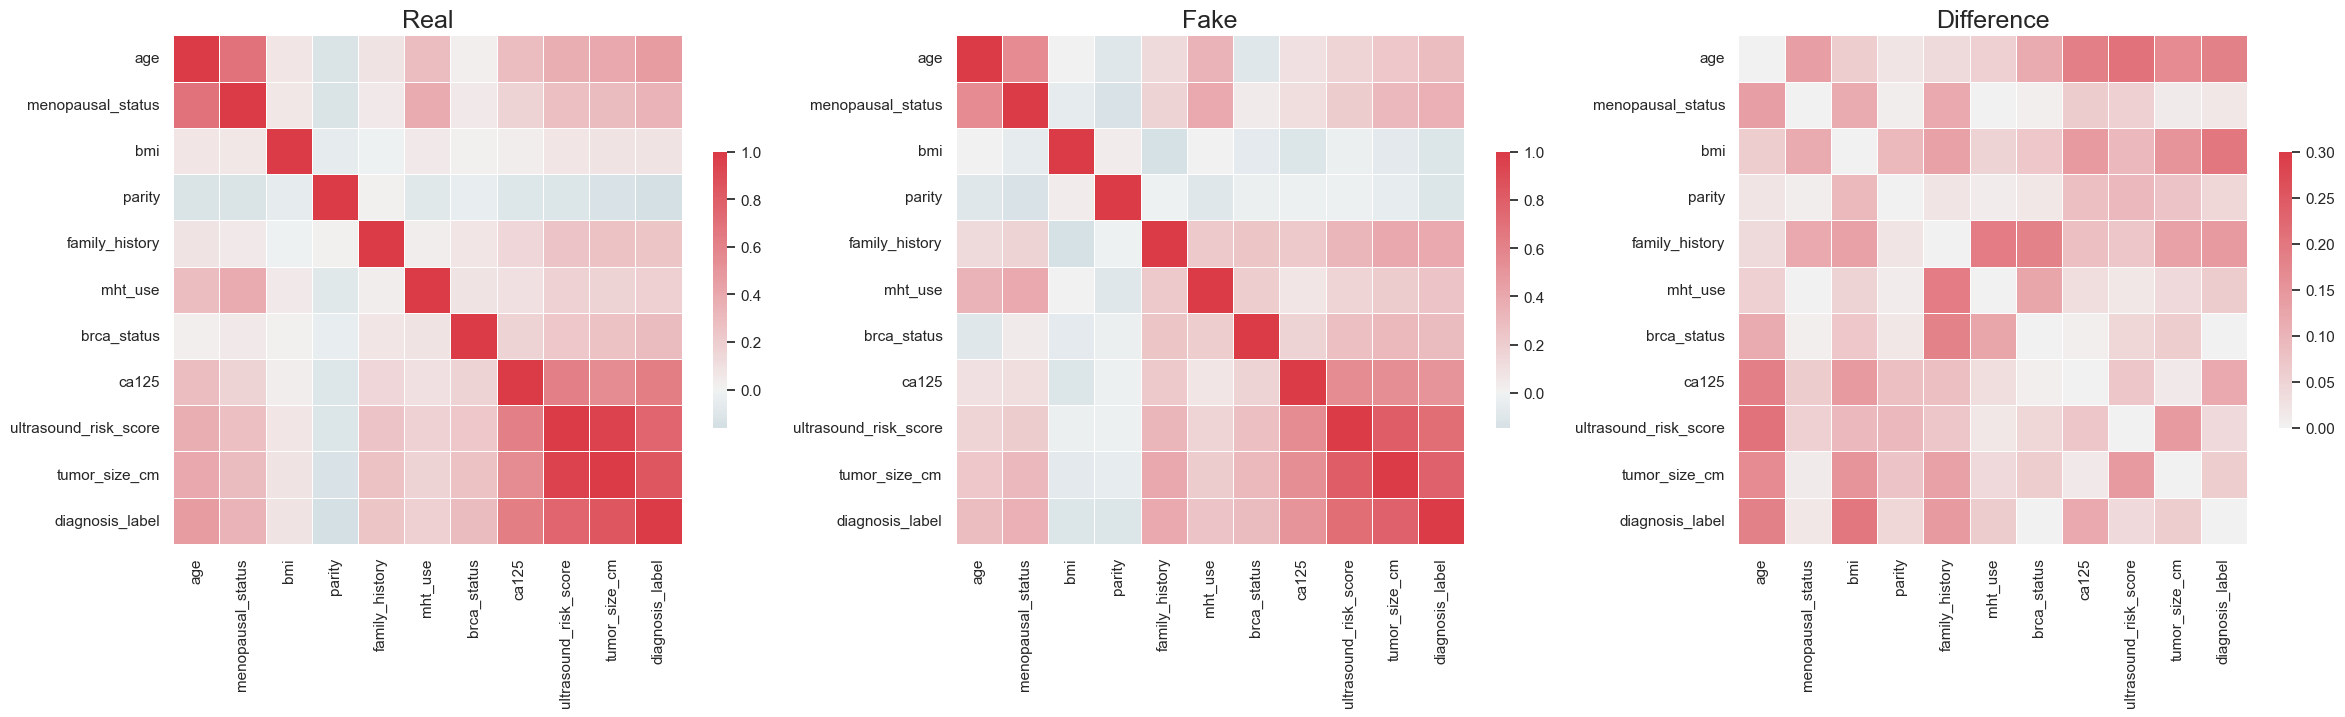

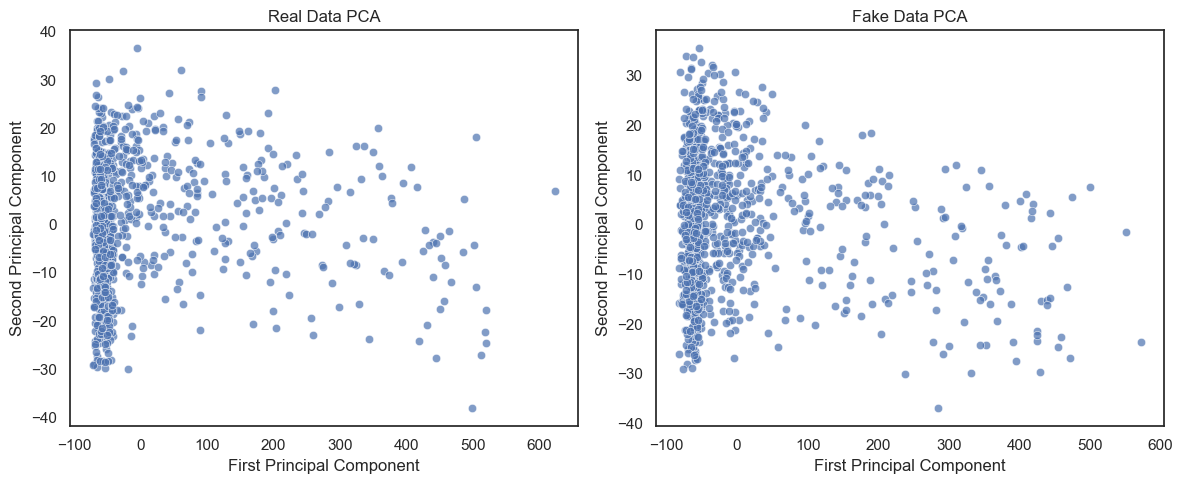

In [5]:
from table_evaluator import TableEvaluator

print(real_data.shape, synthetic_data.shape)
table_evaluator =  TableEvaluator(real_data, synthetic_data)

table_evaluator.visual_evaluation()